In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
data = pd.read_csv('google_stock_5min_20days_2024.csv', parse_dates=['date'], index_col='date')

# Ensure the data is sorted by date
data = data.sort_index()

In [2]:
# Select the 'close' column for prediction
data = data[['4. close']]

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

In [3]:
# Create a function to create sequences of data
def create_sequences(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Define the time step (1 day)
time_step = 1

# Create sequences
X, y = create_sequences(scaled_data, time_step)

# Reshape X to be [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [4]:
# Split the data into training and testing sets
train_size = int(len(X) * 0.8)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]

In [5]:
# Build the BiLSTM model
model = Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(time_step, 1)))
model.add(Bidirectional(LSTM(50)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [6]:
#Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=32, callbacks=[early_stop], verbose=1)

Epoch 1/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.1565 - val_loss: 0.0061
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0029 - val_loss: 6.3497e-04
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.9536e-04 - val_loss: 6.6985e-04
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 1.7265e-04 - val_loss: 7.2187e-04
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.8257e-04 - val_loss: 7.9864e-04
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.5329e-04 - val_loss: 6.9367e-04
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1607e-04 - val_loss: 6.7703e-04
Epoch 8/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6866e-04 - val_loss: 7.0823e-04
Epoch 9/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0065e-04 - val_loss: 6.3211e-04
Epoch 10/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6419e-04 - val_loss: 7.1857e-04
Epoch 11/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - lo

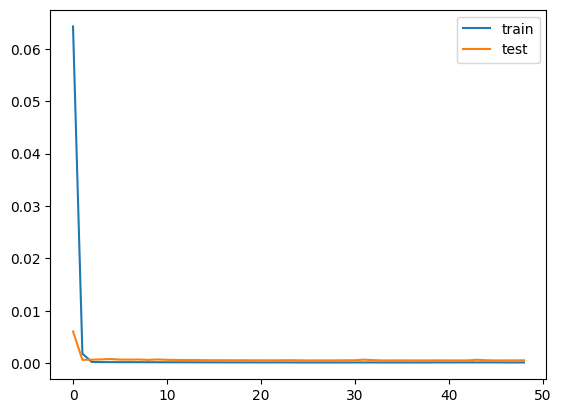

In [7]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [8]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

106/106 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [9]:
# Inverse transform the predictions to get the actual values
train_predict = scaler.inverse_transform(train_predict.reshape(-1, 1))
test_predict = scaler.inverse_transform(test_predict.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

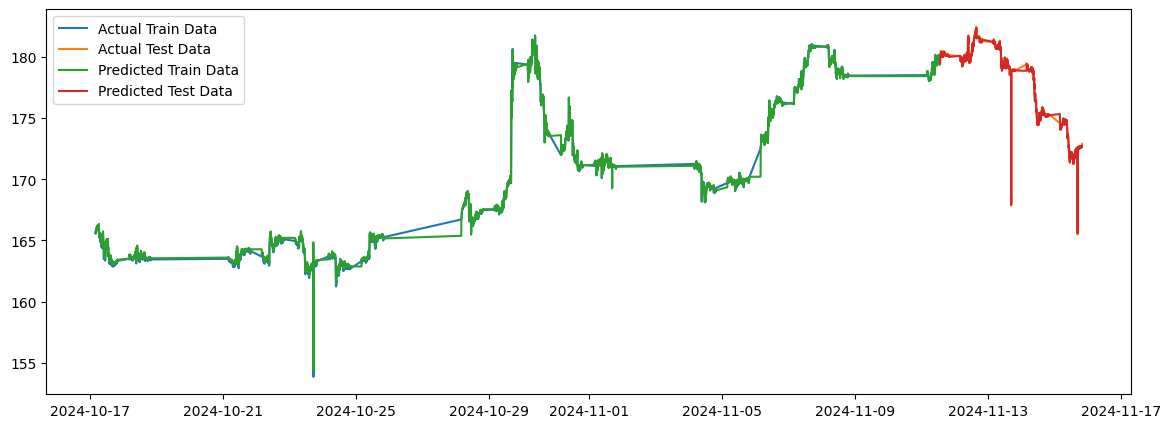

In [10]:
# Plot the results
plt.figure(figsize=(14,5))
plt.plot(data.index[time_step:train_size+time_step], y_train, label='Actual Train Data')
plt.plot(data.index[train_size+time_step:], y_test, label='Actual Test Data')
plt.plot(data.index[time_step:train_size+time_step], train_predict, label='Predicted Train Data')
plt.plot(data.index[train_size+time_step:], test_predict, label='Predicted Test Data')
plt.legend()
plt.show()

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
mse = mean_squared_error(y_test[:, 0], test_predict[:, 0])
mae = mean_absolute_error(y_test[:, 0], test_predict[:, 0])
r2 = r2_score(y_test[:, 0], test_predict[:, 0])

print('MSE:',mse)
print('MAE',mae)
print('R2',r2)

MSE: 0.43356652838919746
MAE 0.16110333987264197
R2 0.9581501459184358
